## Import Library

In [1]:
import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend" #for Mac
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
#os.environ["CUDA_VISIBLE_DEVICES"]='1'
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
pd.options.display.max_columns = None

## Load Data and Preprocessing

In [2]:
import datatable
df_amc = datatable.fread('./1205_asan_raw_v1.csv', na_strings=['']).to_pandas()
df_eumc = datatable.fread('./1205_eumc_raw2.csv', na_strings=['', 'NA']).to_pandas()
df_snuh = datatable.fread("./snuh_2004_2019_v2.csv", na_strings=['']).to_pandas()
df_snuh = df_snuh[df_snuh['asa'].notnull()].reset_index(drop=True)
df_amc = df_amc[df_amc['ASA'].notnull()].reset_index(drop=True)
df_snuh['sex'] = np.where(df_snuh['sex']=='M', 1, 0)
df_eumc['sex'] = np.where(df_eumc['sex']==1, 1, 0)
#df_amc['bmi'] = df_amc['weight'] / (df_amc['height']/100)**2

### Variable Selection

In [3]:
var_list = ['age','bmi','sex', 'preop_alb','preop_bun','preop_cr','preop_glu','preop_gpt','preop_got','preop_hb','preop_k','preop_na','preop_plt','preop_wbc']

## Train Test split

In [4]:
X_snuh = df_snuh[var_list]

## Missing Imputation
X_snuh.fillna(df_snuh.median(), inplace=True)
y_snuh = df_snuh['death30']
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_snuh, y_snuh, test_size=0.2, stratify=y_snuh, random_state=1004)

/home/khl256/anaconda3/envs/deeplearning/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

## Model

In [6]:
def my_model(hidden_layer_num, node_size, batch_normalization, drop_out, drop_out_rate, learning_rate):
    
    ### clear memory
    if K.backend() == 'tensorflow':
        K.clear_session()
    
    model = keras.Sequential()

    ### Input Layer
    model.add(keras.layers.InputLayer(input_shape=(14,)))
    
    ### Hidden Layer
    for i in range(hidden_layer_num):
        model.add(keras.layers.Dense(node_size))
        if batch_normalization: model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.ReLU())
        if drop_out: model.add(keras.layers.Dropout(drop_out_rate))    
    
    ### Output Layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    ### Compile
    model.compile(optimizer= keras.optimizers.Adam(learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=["accuracy"])
    
    return model

In [7]:
model = my_model(hidden_layer_num=5, node_size=1000, drop_out=True, drop_out_rate=0.4, batch_normalization=True, 
                 learning_rate=0.001)

In [8]:
model.fit(X_train_scaled, y_train, batch_size=2**8, epochs=15, validation_data=(X_test_scaled, y_test))

Epoch 1/15
659/659 [==============================] - 6s 9ms/step - loss: 0.0194 - accuracy: 0.9971 - val_loss: 0.0110 - val_accuracy: 0.9977
Epoch 2/15
659/659 [==============================] - 5s 8ms/step - loss: 0.0121 - accuracy: 0.9977 - val_loss: 0.0112 - val_accuracy: 0.9976
Epoch 3/15
659/659 [==============================] - 5s 8ms/step - loss: 0.0114 - accuracy: 0.9977 - val_loss: 0.0109 - val_accuracy: 0.9977
Epoch 4/15
659/659 [==============================] - 5s 8ms/step - loss: 0.0114 - accuracy: 0.9978 - val_loss: 0.0106 - val_accuracy: 0.9977
Epoch 5/15
659/659 [==============================] - 5s 8ms/step - loss: 0.0113 - accuracy: 0.9977 - val_loss: 0.0113 - val_accuracy: 0.9977
Epoch 6/15
659/659 [==============================] - 5s 8ms/step - loss: 0.0113 - accuracy: 0.9978 - val_loss: 0.0112 - val_accuracy: 0.9977
Epoch 7/15
659/659 [==============================] - 5s 8ms/step - loss: 0.0111 - accuracy: 0.9977 - val_loss: 0.0117 - val_accuracy: 0.9977
Epoch 

Instructions for updating:
Please use `model.predict()` instead.
AUROC: 0.9286252351691653


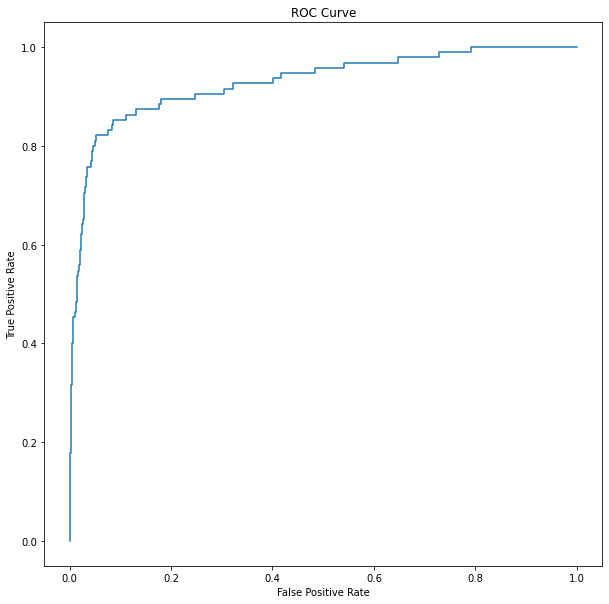

AUPRC: 0.11663952761565394


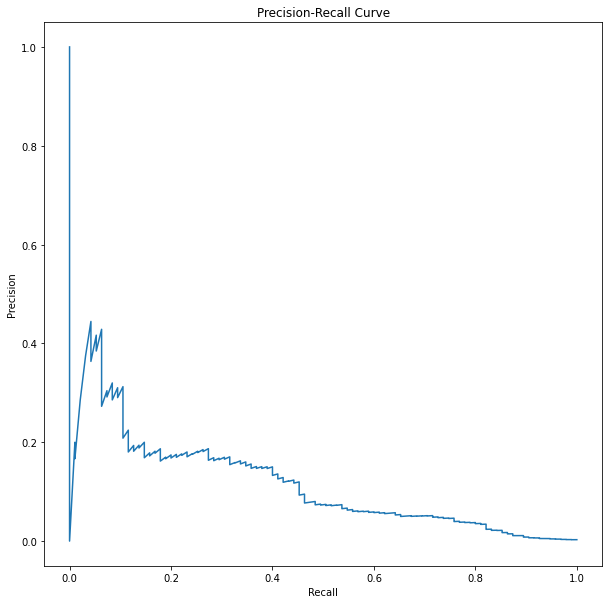

In [9]:
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_test_proba = model.predict_proba(X_test_scaled)
print("AUROC: {}".format(roc_auc_score(y_test, y_test_proba)))

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
#plot_roc_curve(estimator=model, X=fpr, y=tpr)
plt.figure(figsize=(10,10))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot(fpr, tpr)
plt.show()

from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

print("AUPRC: {}".format(average_precision_score(y_test, y_test_proba)))

prec, recall, _ = precision_recall_curve(y_test, y_test_proba)

#PrecisionRecallDisplay(precision=prec, recall=recall).plot()
plt.figure(figsize=(10,10))
plt.plot(recall, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## External Validation

## Asan 

In [10]:
X_amc = df_amc[var_list]
X_amc.fillna(X_amc.median(), inplace=True)
X_amc = pd.DataFrame(scaler.transform(X_amc))
y_amc = df_amc['death30']*1

/home/khl256/anaconda3/envs/deeplearning/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [11]:
X_train_amc, X_test_amc, y_train_amc, y_test_amc = train_test_split(X_amc, y_amc, stratify=y_amc, test_size=0.5, random_state=1004)

In [12]:
model.fit(X_train_amc, y_train_amc, epochs=2, batch_size=2**7)

Epoch 1/2
86/86 [==============================] - 1s 7ms/step - loss: 0.0123 - accuracy: 0.9977
Epoch 2/2
86/86 [==============================] - 1s 7ms/step - loss: 0.0109 - accuracy: 0.9977


AUROC: 0.8975148578220719


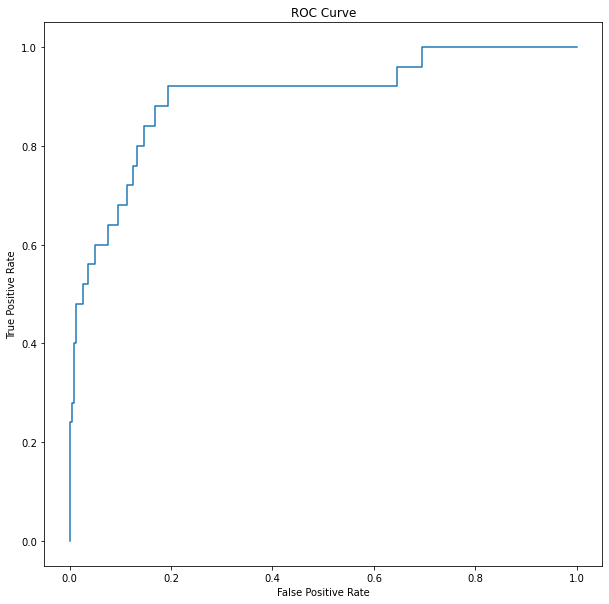

AUPRC: 0.18179001927245012


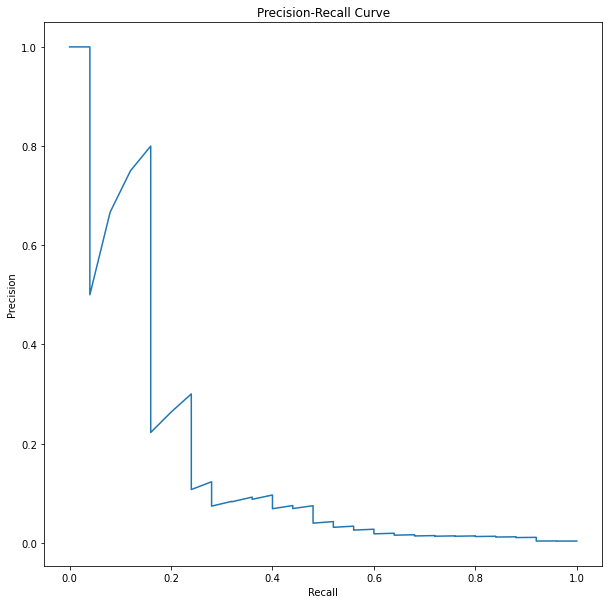

In [13]:
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_test_proba = model.predict_proba(X_test_amc)
print("AUROC: {}".format(roc_auc_score(y_test_amc, y_test_proba)))

fpr, tpr, _ = roc_curve(y_test_amc, y_test_proba)
#plot_roc_curve(estimator=model, X=fpr, y=tpr)
plt.figure(figsize=(10,10))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot(fpr, tpr)
plt.show()

from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

print("AUPRC: {}".format(average_precision_score(y_test_amc, y_test_proba)))

prec, recall, _ = precision_recall_curve(y_test_amc, y_test_proba)

#PrecisionRecallDisplay(precision=prec, recall=recall).plot()
plt.figure(figsize=(10,10))
plt.plot(recall, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

AUROC: 0.9363600621742709


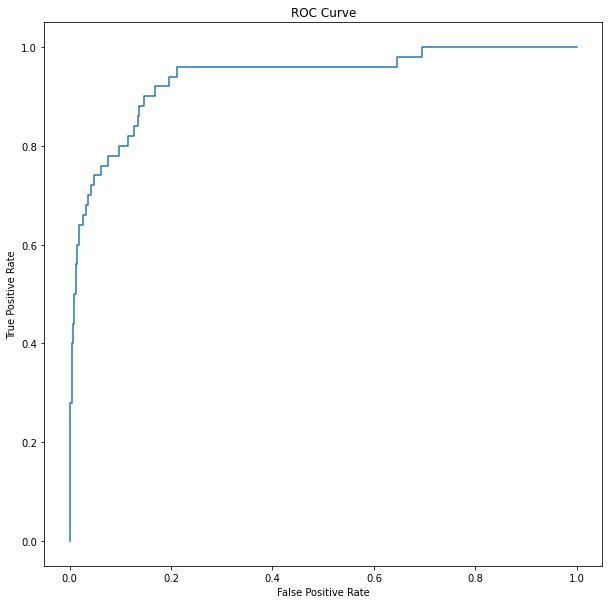

AUPRC: 0.17722467746653925


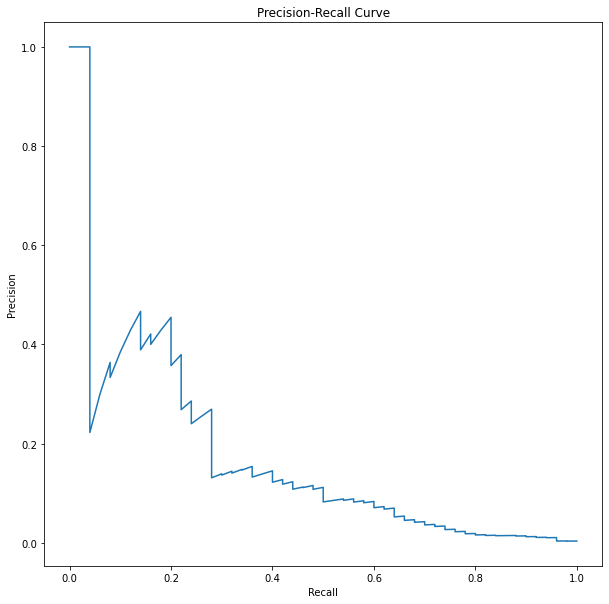

In [14]:
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_test_proba = model.predict_proba(X_amc)
print("AUROC: {}".format(roc_auc_score(y_amc, y_test_proba)))

fpr, tpr, _ = roc_curve(y_amc, y_test_proba)
#plot_roc_curve(estimator=model, X=fpr, y=tpr)
plt.figure(figsize=(10,10))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot(fpr, tpr)
plt.show()

from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

print("AUPRC: {}".format(average_precision_score(y_amc, y_test_proba)))

prec, recall, _ = precision_recall_curve(y_amc, y_test_proba)

#PrecisionRecallDisplay(precision=prec, recall=recall).plot()
plt.figure(figsize=(10,10))
plt.plot(recall, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## EUMC

In [15]:
X_eumc = df_eumc[var_list]
X_eumc.fillna(X_eumc.median(), inplace=True)
X_eumc = pd.DataFrame(scaler.transform(X_eumc))
y_eumc = df_eumc['death_inhosp']*1

/home/khl256/anaconda3/envs/deeplearning/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


AUROC: 0.9006999276850184


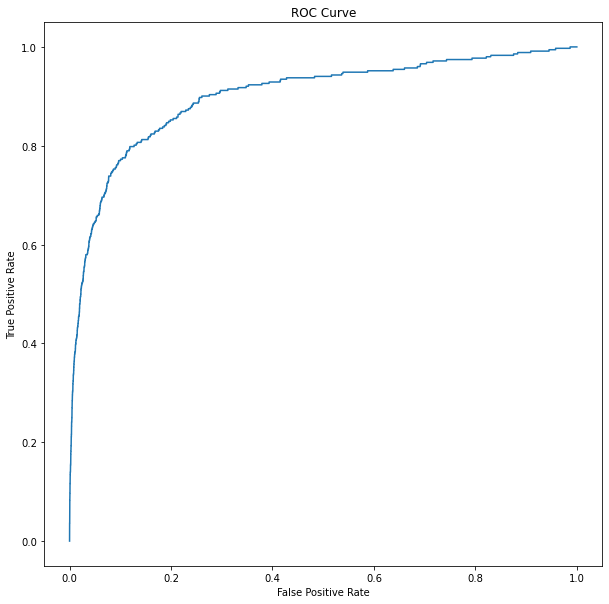

AUPRC: 0.25079101874362253


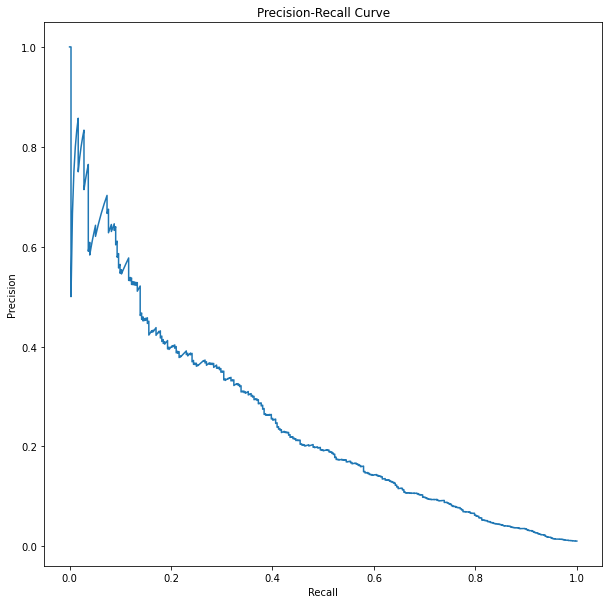

In [16]:
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_test_proba = model.predict_proba(X_eumc)
print("AUROC: {}".format(roc_auc_score(y_eumc, y_test_proba)))

fpr, tpr, _ = roc_curve(y_eumc, y_test_proba)
#plot_roc_curve(estimator=model, X=fpr, y=tpr)
plt.figure(figsize=(10,10))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot(fpr, tpr)
plt.show()

from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

print("AUPRC: {}".format(average_precision_score(y_eumc, y_test_proba)))

prec, recall, _ = precision_recall_curve(y_eumc, y_test_proba)

#PrecisionRecallDisplay(precision=prec, recall=recall).plot()
plt.figure(figsize=(10,10))
plt.plot(recall, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()